## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.table import Table

from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import TableModel
from gammapy.irf import load_cta_irfs

In [2]:
!gammapy info


System:

	python_executable      : /Users/jer/anaconda/envs/gammapy-dev/bin/python 
	python_version         : 3.7.0      
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	path                   : /Users/jer/git/gammapy/gammapy/gammapy 
	version                : 0.9.dev7902 
	githash                : 93b4238ae6a3c36e605f77eaa16b9def0692b34d 


Other packages:

	numpy                  : 1.15.4     
	scipy                  : 1.1.0      
	matplotlib             : 3.0.2      
	cython                 : 0.29       
	astropy                : 3.0.5      
	astropy_healpix        : 0.3.1      
	reproject              : 0.4        
	sherpa                 : 4.10.1     
	pytest                 : 4.0.0      
	sphinx                 : 1.7.9      
	healpy                 : 1.12.5     
	regions                : 0.3        
	iminuit                : 1.3.3      
	naima                  : 0.8.1      
	uncertainties          : 3.0.3      


Gammapy environme

### Prepare model from an ASCI Table

In [3]:
opts = {
   'format': 'ascii',
   'names': ['e_ref', 'e2_flux'], 
}

t = Table.read('../datasets/spectra_CIRELLI11_EW_GAMMA_m2000.txt', **opts)

# Let's add some units
t['e_ref'].unit, t['e2_flux'].unit = "MeV", "cm-2 s-1 MeV"

In [4]:
t

e_ref,e2_flux
MeV,MeV / (cm2 s)
float64,float64
1000.0,3.61e-12
1089.8,3.95e-12
1187.8,4.33e-12
1294.5,4.73e-12
1410.8,5.16e-12
1537.5,5.62e-12
1675.6,6.11e-12
1826.2,6.64e-12


In [5]:
### Boost flux
t['dnde'] = t['e2_flux']/(t['e_ref']*t['e_ref'])*10e3
t['dnde'].unit = "cm-2 s-1 MeV-1"

In [6]:
t

e_ref,e2_flux,dnde
MeV,MeV / (cm2 s),1 / (cm2 MeV s)
float64,float64,float64
1000.0,3.61e-12,3.61e-14
1089.8,3.95e-12,3.325856359177129e-14
1187.8,4.33e-12,3.069030853357e-14
1294.5,4.73e-12,2.8226500058705753e-14
1410.8,5.16e-12,2.5925002063951717e-14
1537.5,5.62e-12,2.3774208473792055e-14
1675.6,6.11e-12,2.176208523032706e-14
1826.2,6.64e-12,1.9910006530602085e-14


In [7]:
mask = t['dnde']>1e-30
t = t[mask]

In [8]:
t

e_ref,e2_flux,dnde
MeV,MeV / (cm2 s),1 / (cm2 MeV s)
float64,float64,float64
1000.0,3.61e-12,3.61e-14
1089.8,3.95e-12,3.325856359177129e-14
1187.8,4.33e-12,3.069030853357e-14
1294.5,4.73e-12,2.8226500058705753e-14
1410.8,5.16e-12,2.5925002063951717e-14
1537.5,5.62e-12,2.3774208473792055e-14
1675.6,6.11e-12,2.176208523032706e-14
1826.2,6.64e-12,1.9910006530602085e-14


### Define spectral model

In [9]:
# Offset to evaluate IRFs
offset = 0.5 * u.deg

# Energy from 0.01 to 10 TeV with 10 bins
energy = t['e_ref'].data * t['e_ref'].unit
values = t['dnde'].data * t['dnde'].unit

In [10]:
model = TableModel(
    energy=energy,
    values=values,
)

### Load IRFs

In [11]:
irfs = load_cta_irfs("$CTADATA/caldb/data/cta/1dc/bcf/South_z40_50h/irf_file.fits")
for k, v in irfs.items():
    print(k, v)

aeff EffectiveAreaTable2D
NDDataArray summary info
energy         : size =    42, min =  0.014 TeV, max = 177.828 TeV
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size =   252, min =  0.000 m2, max = 7238342.000 m2

bkg Background3D
NDDataArray summary info
energy         : size =    21, min =  0.016 TeV, max = 158.489 TeV
fov_lon        : size =    36, min = -5.833 deg, max =  5.833 deg
fov_lat        : size =    36, min = -5.833 deg, max =  5.833 deg
Data           : size = 27216, min =  0.000 1 / (MeV s sr), max =  0.259 1 / (MeV s sr)

edisp EnergyDispersion2D
NDDataArray summary info
e_true         : size =   500, min =  0.005 TeV, max = 495.450 TeV
migra          : size =   300, min =  0.005, max =  2.995
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size = 900000, min =  0.000, max = 27173.320

psf <gammapy.irf.psf_gauss.EnergyDependentMultiGaussPSF object at 0x10ff6cef0>


NDDataArray summary info
energy         : size =    42, min =  0.014 TeV, max = 177.828 TeV
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size =   252, min =  0.000 m2, max = 7238342.000 m2



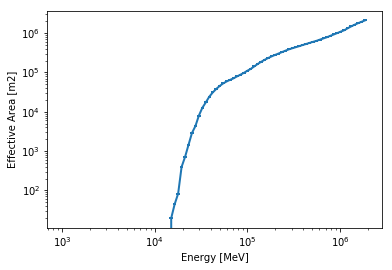

In [12]:
aeff = irfs['aeff'].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(irfs['aeff'].data)

NDDataArray summary info
e_true         : size =    88, min = 1043.935 MeV, max = 1859079.514 MeV
e_reco         : size =    88, min = 1043.935 MeV, max = 1859079.514 MeV
Data           : size =  7744, min =  0.000, max =  1.000



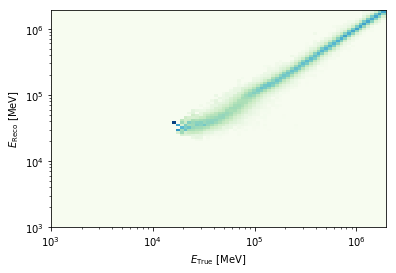

In [13]:
edisp = irfs['edisp'].to_energy_dispersion(
    offset=offset, e_true=energy, e_reco=energy
)
edisp.plot_matrix()
print(edisp.data)

### Simulate data

In [14]:
# observation time
livetime = 5 * u.h

In [15]:
# Simulate data
sim = SpectrumSimulation(
    aeff=aeff, edisp=edisp, source_model=model, livetime=livetime
)
sim.simulate_obs(obs_id=0)

*** Observation summary report ***
Observation Id: 0
Livetime: 5.000 h
On events: 230
Off events: 0
Alpha: 1.000
Bkg events in On region: 0.00
Excess: 230.00
Excess / Background: inf
Gamma rate: 46.00 1 / h
Bkg rate: 0.00 1 / min
Sigma: nan
energy range: 1000.00 MeV - 1940800.00 MeV


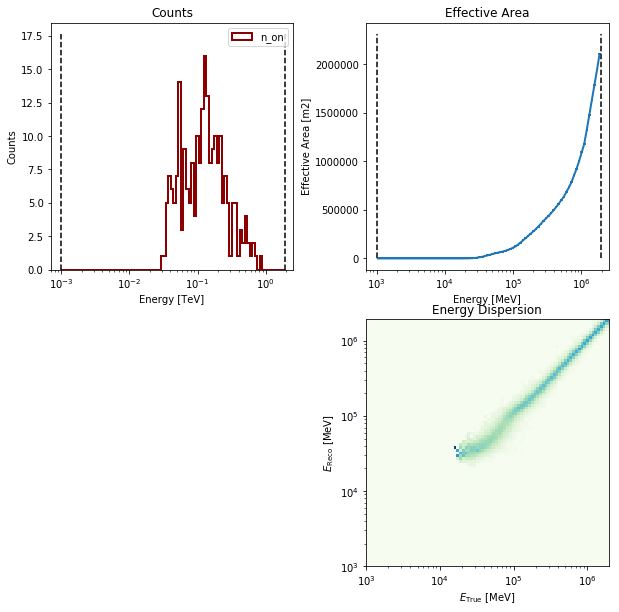

In [16]:
sim.obs.peek()
print(sim.obs)